In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [ ]:
import zipfile
import os

zip_path = "pollendataset.zip"
extract_dir = "MyDrive/content/pollen_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted to:", extract_dir)

Extracted to: MyDrive/content/pollen_dataset


In [ ]:
import os

categories = os.listdir(extract_dir)
print("Classes:", categories)

Classes: ['images', 'bboxes.csv', 'class_map.csv']


In [ ]:
import cv2
import numpy as np
import os
import pandas as pd

img_size = 84
X, y = [], []

images_folder = os.path.join(extract_dir, 'images')
class_map_path = os.path.join(extract_dir, 'class_map.csv')

# Read the class map without header and assign column names
class_map_df = pd.read_csv(class_map_path, header=None, names=['class_name', 'class_id'])
class_map = dict(zip(class_map_df['class_id'], class_map_df['class_name']))

# Assuming bboxes.csv contains image filenames and their corresponding class_id
bboxes_path = os.path.join(extract_dir, 'bboxes.csv')
# Read bboxes.csv without header and assign column names based on inspection
bboxes_df = pd.read_csv(bboxes_path, header=None, names=['image_filename', 'x_min', 'y_min', 'x_max', 'y_max', 'class_name'])


# Create a dictionary mapping image filename to class_name first, then map class_name to class_id
# Assuming 'image_filename' is the first column (index 0) and 'class_name' is the last column (index 5)
image_class_name_map = dict(zip(bboxes_df['image_filename'], bboxes_df['class_name']))

# Create a mapping from class_name to class_id from class_map_df
class_name_to_id = dict(zip(class_map_df['class_name'], class_map_df['class_id']))

if os.path.isdir(images_folder):
    print(f"Loading images from: {images_folder}")

    # Get the unique class IDs from the class_map_df to determine the number of classes
    unique_class_ids = sorted(class_map_df['class_id'].unique())
    num_classes = len(unique_class_ids)
    print(f"Detected {num_classes} classes.")

    for file in os.listdir(images_folder):
        path = os.path.join(images_folder, file)
        # Check if it's a file, not a hidden file, and if its filename exists in the bboxes_df mapping
        if os.path.isfile(path) and not file.startswith('.') and file in image_class_name_map:
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                # Get the class_name for the image
                class_name = image_class_name_map[file]
                # Get the corresponding class_id
                if class_name in class_name_to_id:
                    class_id = class_name_to_id[class_name]
                    y.append(class_id) # Append the class_id
                else:
                    print(f"Warning: Class name '{class_name}' for image '{file}' not found in class map.")


X = np.array(X) / 255.0
y = np.array(y) # Convert y to a numpy array


print(f"Loaded {len(X)} images.")
print(f"Labels generated for {len(y)} images.")

Loading images from: MyDrive/content/pollen_dataset/images
Detected 20 classes.
Loaded 2412 images.
Labels generated for 2412 images.


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np # Import numpy if not already imported

# Ensure y is a numpy array before splitting
y = np.array(y)

# Split into training and test sets using stratified splitting
# Use the original integer labels for stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Use stratify=y
)

# Convert labels to categorical AFTER the split
# Assuming num_classes is defined from the data loading
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# No need to import to_categorical here, as it's done after the split


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(84, 84, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax') # Use num_classes here
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 383ms/step - accuracy: 0.8691 - loss: 0.4513 - val_accuracy: 0.7764 - val_loss: 0.7600
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 371ms/step - accuracy: 0.8750 - loss: 0.3974 - val_accuracy: 0.8137 - val_loss: 0.7967
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - accuracy: 0.8821 - loss: 0.3592 - val_accuracy: 0.7805 - val_loss: 0.8511
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 399ms/step - accuracy: 0.8761 - loss: 0.3983 - val_accuracy: 0.7867 - val_loss: 0.9215
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 381ms/step - accuracy: 0.9086 - loss: 0.3211 - val_accuracy: 0.8178 - val_loss: 0.7598
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.9139 - loss: 0.2603 - val_accuracy: 0.8137 - val_loss: 0.8391
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 378ms/step - accuracy: 0.9246 - loss: 0.2698 - val_accuracy: 0.8075 - val_loss: 0.7610
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 359ms/step - accuracy: 0.9265 - loss: 0.2315 - val_accu

In [ ]:
model.save('trained_model.h5')

In [ ]:
from google.colab import files
files.download('trained_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving img2.png to img2.png
Saving img1.png to img1.png



📷 Analyzing: img3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


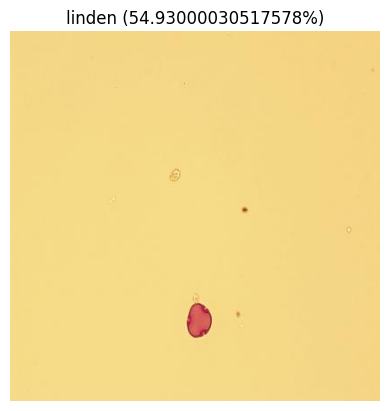


📷 Analyzing: img2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


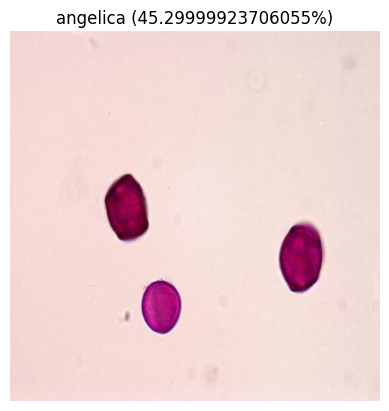


📷 Analyzing: img1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


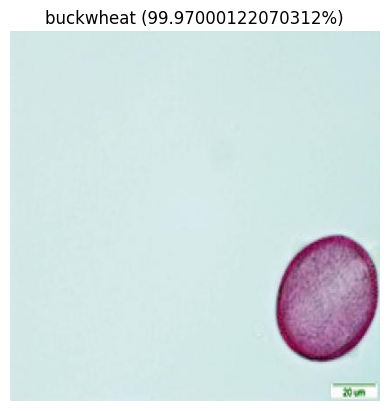

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd # Import pandas

# Define extract_dir
extract_dir = "MyDrive/content/pollen_dataset"

# Load the trained model
model = load_model('trained_model.h5')

# Load class_map.csv again here
class_map_path = os.path.join(extract_dir, 'class_map.csv')
class_map_df = pd.read_csv(class_map_path, header=None, names=['class_name', 'class_id'])
class_map = dict(zip(class_map_df['class_id'], class_map_df['class_name']))


# Loop through all uploaded files
for filename in os.listdir():
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
        print(f"\n📷 Analyzing: {filename}")
        img_path = os.path.join(os.getcwd(), filename) # Get the full path to the uploaded file
        img_cv = cv2.imread(img_path) # Use cv2.imread for displaying

        if img_cv is not None: # Check if the image was successfully loaded by cv2
            # Ensure the image data is in a suitable format and data type for imshow
            if isinstance(img_cv, np.ndarray) and img_cv.dtype != object:
                 # Convert BGR to RGB for displaying with matplotlib
                img_display = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)


                img = load_img(img_path, target_size=(84, 84)) # Use load_img for model input
                img_array = img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)

                prediction = model.predict(img_array)
                predicted_class_id = np.argmax(prediction)
                # Get the class label using the class_map dictionary
                label = class_map.get(predicted_class_id, "Unknown Class") # Use .get to handle potential missing keys
                confidence = round(np.max(prediction) * 100, 2)

                # Show the image with prediction
                plt.imshow(img_display)
                plt.axis('off')
                plt.title(f"{label} ({confidence}%)")
                plt.show()
            else:
                print(f"❌ Image data for {filename} is not in a standard format.")
        else:
            print(f"❌ Could not read image: {filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
⚠️ Could not process img3.jpg: list index out of range
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

📷 img2.jpg → Prediction: Cuprissaceae (45.29999923706055%)


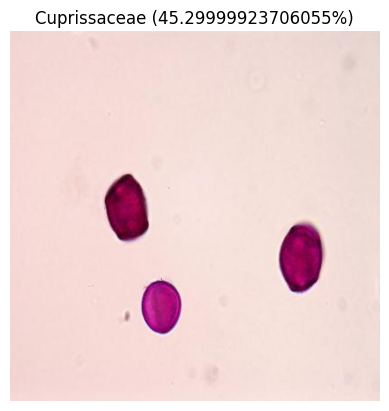

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

📷 img1.jpg → Prediction: Anomalous (99.97000122070312%)


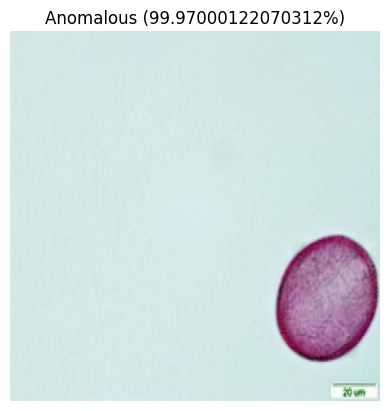

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Load your trained model
model = load_model('trained_model.h5')
classes = ['Anomalous', 'Alnus', 'Cuprissaceae', 'Debris', 'Normal']  # Adjust if your dataset differs

# Loop through uploaded images
image_files = [f for f in os.listdir() if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for filename in image_files:
    try:
        # Load and preprocess image
        img = load_img(filename, target_size=(84, 84))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)
        label = classes[np.argmax(prediction)]
        confidence = round(np.max(prediction) * 100, 2)

        # Display result
        print(f"\n📷 {filename} → Prediction: {label} ({confidence}%)")
        plt.imshow(cv2.imread(filename)[..., ::-1])
        plt.axis('off')
        plt.title(f"{label} ({confidence}%)")
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not process {filename}: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
⚠️ Could not process img3.jpg: list index out of range
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


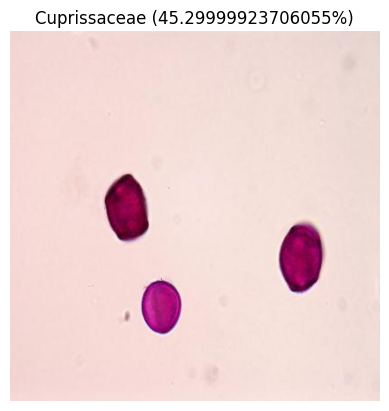

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


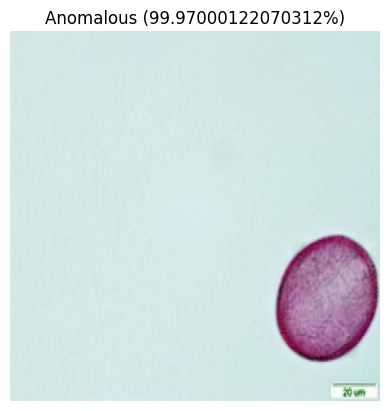

✅ Results saved to pollen_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Load your trained model
model = load_model('trained_model.h5')
classes = ['Anomalous', 'Alnus', 'Cuprissaceae', 'Debris', 'Normal']

# List of predictions
results = []

# Predict for each image
image_files = [f for f in os.listdir() if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for filename in image_files:
    try:
        img = load_img(filename, target_size=(84, 84))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        label = classes[np.argmax(prediction)]
        confidence = round(np.max(prediction) * 100, 2)

        # Save result
        results.append({'Filename': filename, 'Prediction': label, 'Confidence (%)': confidence})

        # Optional: Show image
        plt.imshow(cv2.imread(filename)[..., ::-1])
        plt.title(f"{label} ({confidence}%)")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not process {filename}: {e}")

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("pollen_predictions.csv", index=False)
print("✅ Results saved to pollen_predictions.csv")

# Download CSV file
from google.colab import files
files.download("pollen_predictions.csv")

In [ ]:
import pandas as pd

# Create and display the table
df = pd.DataFrame(results)
df.index += 1  # start index at 1 instead of 0
from IPython.display import display
display(df.style.set_caption("📋 Pollen Grain Classification Results"))

,Filename,Prediction,Confidence (%)
1,img2.jpg,Cuprissaceae,45.299999
2,img1.jpg,Anomalous,99.970001


In [38]:
import gradio as gr
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load model and define class labels
model = load_model('trained_model.h5')
classes = ['Anomalous', 'Alnus', 'Cuprissaceae', 'Debris', 'Normal']

def classify_pollen(image):
    img = image.resize((84, 84))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    confidences = {classes[i]: float(pred[0][i]) for i in range(len(classes))}
    predicted_label = classes[np.argmax(pred)]

    return predicted_label, confidences

# Build the interface
interface = gr.Interface(
    fn=classify_pollen,
    inputs=gr.Image(type="pil"),
    outputs=["label", "label"],
    title="🌼 Pollen Grain Classifier",
    description="Upload a microscopic pollen image and get its classification. Model trained on 5 types from the Pollen13K dataset."
)

interface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d09e36eb786e884b2b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Using existing dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d09e36eb786e884b2b.gradio.live
